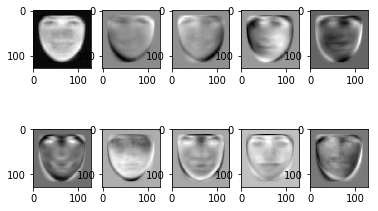

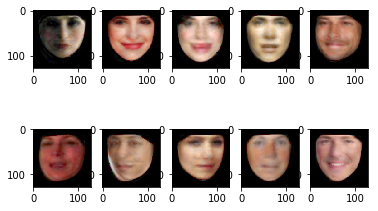

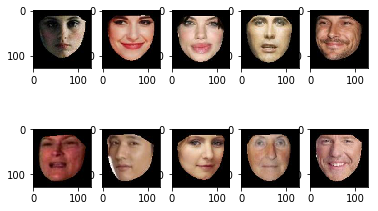

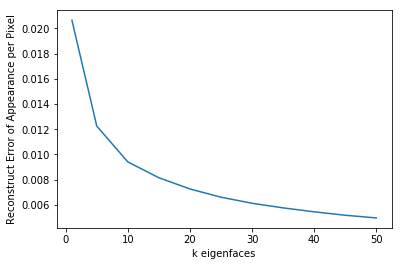

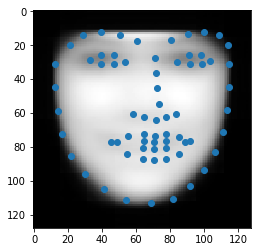

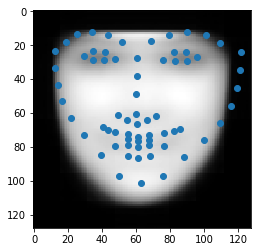

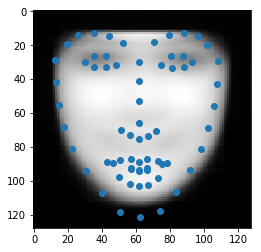

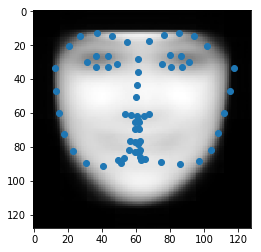

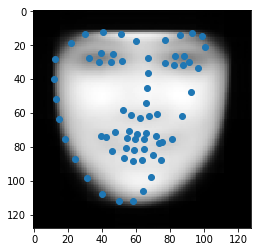

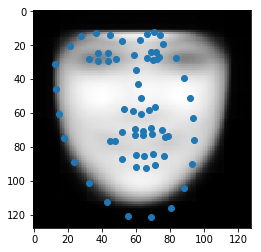

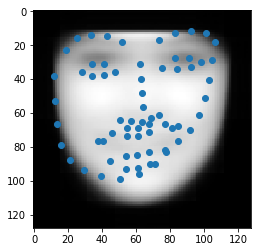

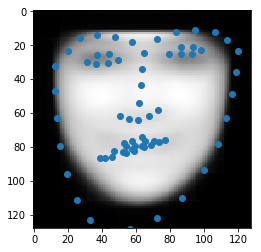

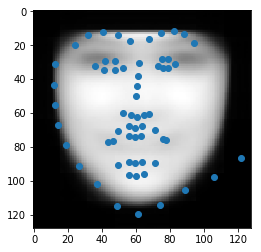

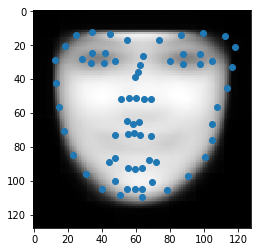

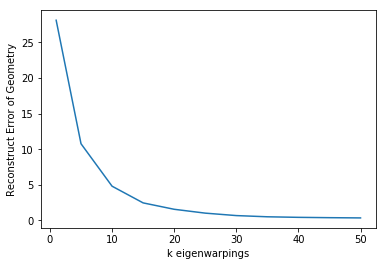

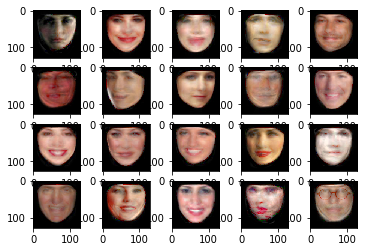

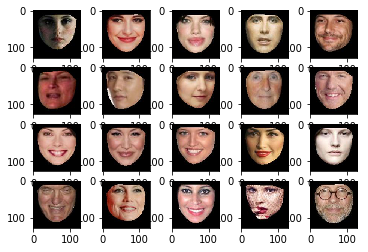

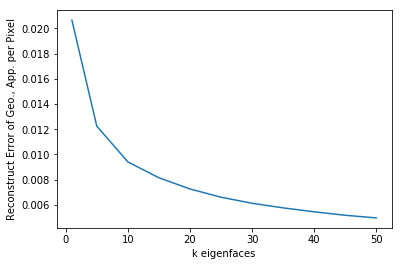

In [2]:
"""
This project compares 3 types of representations in the context of dimension reduction:
2 generative methods, PCA (linear) and Autoencoder (non-linear),
and 1 discriminative method, Fisher Linear Discriminants (FLD).

1000 images (800 training, 200 test)
128 x 128 pixels
68 landmarks (to be aligned geometrically to compare appearance meaningfully)
Training set: calculate eigenvalues and eigenvectors.
Test set: calculate reconstruction errors using eigenvectors

"""
import os
import sys
sys.path.append('/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages')
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import scipy.io as sio
import glob
import math
import cv2
import matplotlib.pyplot as plt
import skimage
from skimage import color
from skimage.io import imread_collection
from mywarper import warp

K = [1,5,10,15,20,25,30,35,40,45,50]

def rgb2hsv_ch(imgs, channel):
    hsv_imgs = []
    for x in imgs:
        hsv_imgs.append(skimage.color.rgb2hsv(x)[:, :, channel])
    return hsv_imgs

def hsv2rgb(imgs):
    rgb_imgs = []
    for x in imgs:
        rgb_imgs.append(skimage.color.hsv2rgb(x))
    return rgb_imgs

def calc_mean(imgs):
    imgs_sum = np.zeros(np.shape(imgs[0]))
    for x in imgs:
        imgs_sum += x
    return imgs_sum / len(imgs)

def normalize(imgs, mean):
    norm_imgs = []
    for x in imgs:
        norm_imgs.append(np.subtract(x, mean))
    return norm_imgs

# X: 800x16384 for training images, 1000x136 for landmarks
def get_X(norm_imgs):
    flat_imgs = []
    for x in norm_imgs:
        flat_imgs.append(x.flatten())
    return np.matrix(flat_imgs)

def calc_eigenfaces(X_train, mean, num):
    X = get_X(normalize(X_train, mean))
    X_tr = X.T
    eigenvalues, eigenvectors = np.linalg.eig(X.dot(X_tr))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]

    eigenfaces = [] # 50 vectors 16384x1
    for i in range(num):
        eigenface = X_tr * eigenvectors[:, i]
        eigenfaces.append((eigenface / np.linalg.norm(eigenface)).real)
    return eigenfaces

def disp_eigenfaces(eigenfaces):
    f, axes = plt.subplots(2, 5)
    for i, eigenface in enumerate(eigenfaces):
        row = 0 if i < 5 else 1
        eigenface = eigenface.reshape(128, 128)
        axes[row, i % 5].imshow(eigenface, cmap='binary_r')
    plt.show()
    
def reconstruct(X_test_v_ch, mean, eigenfaces):
    recon_imgs = []
    for I in X_test_v_ch:
        sum_over_eigenfaces = np.zeros((128**2, 1))
        for eigenface in eigenfaces:
            proj = (I - mean).flatten().dot(eigenface)
            sum_over_eigenfaces += (np.asscalar(proj) * eigenface)
        img = np.reshape(sum_over_eigenfaces, (128, 128))
        recon_imgs.append(img + mean)
    return recon_imgs
    
def disp_recon_images(orig_imgs, recon_imgs):
    recon_hsv_imgs = merge_hsv_ch(orig_imgs, recon_imgs)
    recon_rgb_imgs = hsv2rgb(recon_hsv_imgs)

    f, axes = plt.subplots(2, 5)
    for i, img in enumerate(recon_rgb_imgs):
        row = 0 if i < 5 else 1
        axes[row, i % 5].imshow(img)
    plt.show()
    
    f, axes = plt.subplots(2, 5)
    for i, img in enumerate(orig_imgs):
        row = 0 if i < 5 else 1
        axes[row, i % 5].imshow(img)
    plt.show()
    
def merge_hsv_ch(orig_imgs, recon_imgs):
    hsv_imgs = []
    for i, img in enumerate(orig_imgs):
        h, s = rgb2hsv_ch([img], 0)[0], rgb2hsv_ch([img], 1)[0]
        v = recon_imgs[i].clip(min=0, max=1)
        hsv_imgs.append(cv2.merge([h, s, v]))
    return hsv_imgs

def reconstruct_per_k_eigenfaces(X_test_v_ch, mean, eigenfaces):
    recon_imgs_per_k = []
    for k in K:
        recon_imgs = reconstruct(X_test_v_ch, mean, eigenfaces[:k])
        recon_imgs_per_k.append(recon_imgs)
    return recon_imgs_per_k

def calc_recon_error(recon_imgs_per_k_eigenfaces, X_test):
    recon_error_per_k = []
    for recon_imgs in recon_imgs_per_k_eigenfaces:
        recon_error = 0
        for i, recon_img in enumerate(recon_imgs):
            original = rgb2hsv_ch([X_test[i]], 2)[0]
            recon_error += np.sum(np.square(recon_img - original))
        recon_error_per_k.append(recon_error / 128**2 / 200)
    return recon_error_per_k

def disp_recon_error(recon_errors, x_label, y_label):
    plt.plot(K, recon_errors)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    
def get_landmarks():
    mat_files = glob.glob('./landmarks/*.mat')
    landmarks = []
    for f in mat_files:
        landmark = sio.loadmat(f)['lms']
        # landmark = landmark[landmark[:, 1].argsort()]
        landmarks.append(landmark)
    return landmarks

def calc_eigenwarpings(landmarks, mean, num):
    X = get_X(normalize(landmarks, mean))
    X_tr = X.T
    eigenvalues, eigenvectors = np.linalg.eig(X_tr.dot(X))
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]

    eigenwarpings = [] # 10 vectors 136x1
    for i in range(num):
        eigenwarpings.append(eigenvectors[:, i])
    return eigenwarpings

def disp_eigenwarpings(eigenwarpings, mean, mean_img):
    for eigenwarping in eigenwarpings:
        x, y = [], []
        eigenwarping = np.multiply(eigenwarping.reshape(68, 2), mean) + mean
        for item in eigenwarping[:, 0]:
            x.append(np.asscalar(item))
        for item in eigenwarping[:, 1]:
            y.append(np.asscalar(item))
        plt.plot(x, y, 'o')
        plt.gca().invert_yaxis()
        plt.imshow(mean_img, cmap='binary_r')
        plt.show()
        
def reconstruct_landmarks(landmarks, mean, eigenwarpings):
    recon_landmarks = []
    for landmark in landmarks:
        sum_over_eigenwarpings = np.zeros((136, 1))
        for eigenwarping in eigenwarpings:
            proj = (landmark - mean).flatten().dot(eigenwarping)
            sum_over_eigenwarpings += (np.asscalar(proj) * eigenwarping)
        landmark = np.reshape(sum_over_eigenwarpings, (68, 2))
        recon_landmarks.append(landmark + mean)
    return recon_landmarks

def reconstruct_per_k_eigenwarpings(landmarks_test, landmarks_mean, eigenwarpings):
    recon_landmarks_per_k = []
    for k in K:
        recon_landmarks = reconstruct_landmarks(
            landmarks_test, landmarks_mean, eigenwarpings[:k])
        recon_landmarks_per_k.append(recon_landmarks)
    return recon_landmarks_per_k

def calc_recon_error_landmarks(recon_landmarks_per_k_eigenwarpings, landmarks_test):
    recon_error_per_k = []
    for recon_landmarks in recon_landmarks_per_k_eigenwarpings:
        recon_error = 0
        for i, recon_landmark in enumerate(recon_landmarks): # 200 landmarks
            original = landmarks_test[i]
            recon_error += math.sqrt(np.sum(np.square(np.subtract(original, recon_landmark))))
        recon_error_per_k.append(recon_error / 200)
    return recon_error_per_k

def warp_imgs_to_mean_landmark(imgs, landmarks_mean, recon_test_landmarks):
    warped_imgs = []
    for i, img in enumerate(imgs):
        img = np.expand_dims(img, axis=2)
        warped_img = warp(img, recon_test_landmarks[i], landmarks_mean)
        warped_imgs.append(warped_img)
    return np.squeeze(warped_imgs)

def warp_imgs_to_orig_location(imgs, landmarks_mean, recon_test_landmarks):
    warped_imgs = []
    for i, img in enumerate(imgs):
        img = np.expand_dims(img, axis=2)
        warped_img = warp(img, landmarks_mean, recon_test_landmarks[i])
        warped_imgs.append(warped_img)
    return np.squeeze(warped_imgs)

def disp_warped_images(orig_imgs, recon_imgs):
    recon_hsv_imgs = merge_hsv_ch(orig_imgs, recon_imgs)
    recon_rgb_imgs = hsv2rgb(recon_hsv_imgs)

    f, axes = plt.subplots(4, 5)
    for i, img in enumerate(recon_rgb_imgs):
        row = math.floor(i / 5)
        axes[row, i % 5].imshow(img)
    plt.show()
    
    f, axes = plt.subplots(4, 5)
    for i, img in enumerate(orig_imgs):
        row = math.floor(i / 5)
        axes[row, i % 5].imshow(img)
    plt.show()
    
def run_pca():
    # ----------------------- PCA: Question 1 ------------------------
    # Divide 1000 faces into 800 training and 200 test
    images = imread_collection('./images/*.jpg')
    X_train, X_test = images[:800], images[800:]
    X_train, X_test_v_ch = rgb2hsv_ch(X_train, 2), rgb2hsv_ch(X_test, 2)

    # Compute mean and first K=50 eigen-faces for tr. images with no landmark aligment
    mean = calc_mean(X_train)
    eigenfaces = calc_eigenfaces(X_train, mean, 50)

    # Display the first 10 eigen-faces
    disp_eigenfaces(eigenfaces[:10])
        
    # Use mean and eigen-faces to reconstruct remaining 200 test faces
    recon_imgs = reconstruct(X_test_v_ch, mean, eigenfaces)
    
    # Plot 10 reconstructed faces and the corresponding original faces
    disp_recon_images(X_test[:10], recon_imgs[:10])

    '''
    Plot total reconstruction error (squared intensity difference between
    reconstructed images and their originals) per pixel (i.e. normalize
    the error by pixel number, and average over the testing images) over
    the number of eigen-faces K = 1,5,10,15,...,50.
    '''
    recon_imgs_per_k_eigenfaces = reconstruct_per_k_eigenfaces(
        X_test_v_ch, mean, eigenfaces)
    recon_errors = calc_recon_error(recon_imgs_per_k_eigenfaces, X_test)
    disp_recon_error(recon_errors, 'k eigenfaces', 'Reconstruct Error of Appearance per Pixel')
    

    # ----------------------- PCA: Question 2 ------------------------
    # Compute mean and first K=10 eigen-warpings of landmarks for tr. faces
    landmarks = get_landmarks()
    landmarks_train, landmarks_test = landmarks[:800], landmarks[800:]

    landmarks_mean = calc_mean(landmarks_train)
    eigenwarpings = calc_eigenwarpings(landmarks_train, landmarks_mean, 50)

    # Display the first 10 eigen-warpings (add mean back for meaning)
    disp_eigenwarpings(eigenwarpings[:10], landmarks_mean, mean)
    
    # Use eigen-warpings to reconstruct the landmarks for test faces
    recon_landmarks = reconstruct_landmarks(landmarks_train, landmarks_mean, eigenwarpings)
    
    '''
    Plot the reconstruction error (in terms of distance) over number of
    eigen-warpings K = 1,5,10,15,...,50 (error averaged over test images)
    '''
    recon_landmarks_per_k_eigenwarpings = reconstruct_per_k_eigenwarpings(
        landmarks_test, landmarks_mean, eigenwarpings)
    recon_errors = calc_recon_error_landmarks(recon_landmarks_per_k_eigenwarpings, landmarks_test)
    disp_recon_error(recon_errors, 'k eigenwarpings', 'Reconstruct Error of Geometry')
    
    # ----------------------- PCA: Question 3 ------------------------
    # 1) For each test image, project its landmarks onto top 10 eigen-warpings
    # This produces reconstructed landmarks
    recon_test_landmarks = reconstruct_landmarks(landmarks_test, landmarks_mean, eigenwarpings[:10])
    # print('recon_test_landmarks: ', np.shape(recon_test_landmarks), np.max(recon_test_landmarks[0]), np.min(recon_test_landmarks[0]))
    
    # 2) For each test image, a) warp it to mean position and b) project it onto top 50 eigen-faces
    # This produces the reconstructed image at the mean position
    X_test_aligned = warp_imgs_to_mean_landmark(X_test_v_ch, landmarks_mean, recon_test_landmarks)
    # print('X_test_aligned: ', np.mean(X_test_aligned), np.max(X_test_aligned), np.min(X_test_aligned))
    recon_imgs_aligned = reconstruct(X_test_aligned, mean, eigenfaces)
    # print('recon_imgs: ', np.shape(recon_imgs_aligned), np.max(recon_imgs_aligned[0]), np.min(recon_imgs_aligned[0]))
    
    # Warp the reconstructed face appearances from 2) to the positions reconstructed in 1)
    recon_imgs_landmarked = warp_imgs_to_orig_location(recon_imgs_aligned, landmarks_mean, recon_test_landmarks)

    # Plot 20 reconstructed faces and their corresponding original faces
    disp_warped_images(X_test[:20], recon_imgs_landmarked[:20])

    # Plot reconstruction error per pixel over eigen-faces K = 1,5,10,15,...,50.
    warped_imgs_per_k_eigenfaces = reconstruct_per_k_eigenfaces(
        X_test_v_ch, mean, eigenfaces)
    recon_errors = calc_recon_error(warped_imgs_per_k_eigenfaces, X_test)
    disp_recon_error(recon_errors, 'k eigenfaces', 'Reconstruct Error of Geo., App. per Pixel')
        
def main():
    run_pca()

if __name__ == "__main__":
    main()
